# XRF Spectral Data-Preprocessing
In this notebook, we:<br>
* Perform a running sum on the spectra from the raw XRF data to increase the signal to noise ratio <br>
* Export the data so that it can be reduced in Q-Spec, the ITRAX software.<br>
* Reimport the data and putt XRF element intensities on a depth scale, selecting only the splice intervals<br>

This step is necessitated by noisy data produced by such short rapid exposure times

## Setup
### Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os
import shutil
from IPython.display import clear_output

### Set Paths
The 10 GB of raw data are located on an external hardrive, this link will not work on github.

In [2]:
U1474='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'

### Get Core Names
I'll need to link to a directory in each core's file that has the raw spectra files

In [3]:
U1474_sections=listdir(U1474)
U1474_sections.sort()
U1474_sections=U1474_sections[1:]

## Pre-Process Data
The steps for each core section (213 in all):<br>
1) Load all files in the section's directory as dataframes into a dictionary. <br>
2) Turn that dictionary into a single dataframe, where each column is one of the spectra. <br>
3) Do a 10-pt running sum of those spectra and selected every 10th one. This turns 10 spectra into one taller one. <br>
4) Turn that dataframe back into a a dictionary and a csv that Qspec can read.<br>
5) Write the resulting file into a directory on the external hardrive called 'New XRF Data"<br>

In [7]:
all_results_path='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/New_XRF_Data/'
summed_results_path='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/New_XRF_Data_Summed/'

### Collect Non-Problematic Sections

In [8]:
main=pd.DataFrame(U1474_sections)
main=main[(main.index!=19)&(main.index!=55)&(main.index!=83)&(main.index!=84)]
main=main[0].to_list()[:-1]

### Investigate Range of Normal Total Signals

In [6]:
section_intensities=pd.DataFrame(index=range(0,800))
for section in main: 
    clear_output(wait=True)
    core=U1474+section+'/XRF data/'

    files=listdir(core)
    files.sort()
    
    dct={}
    for file in files:
            dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')
    df=pd.concat([dct[file].iloc[30:,0].astype(int) for file in files],axis='columns')
    df.columns=list(dct.keys())
    df=df.sum()
    
    section_intensities.loc[:len(df)-1,section]=df.values
    print(section)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
fig,ax=plt.subplots(figsize=(16,10))
for col in section_intensities.columns:
    section_intensities[col].plot(ax=ax)
ax.set_ylim(0,6e5)
ax.set_xlabel('Offset in Core (mm)')
ax.set_ylabel('Total Signal (cts)')

### Pre-Process Non-Problem Sections

In [9]:
for section in main[:1]: 
    clear_output(wait=True)
    core=U1474+section+'/XRF data/'

    files=listdir(core)
    files.sort()

    dct={}
    for file in files:
            dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')
    df=pd.concat([dct[file].iloc[30:,0].astype(int) for file in files],axis='columns')
    df.columns=list(dct.keys())

    cleaned=df.loc[:,(df.sum()>100000)&(df.sum()<600000)]

    sumspectra=cleaned.sum(axis=1)
    ss_product=dct['L000000.spe']
    ss_product.iloc[30:,0]=sumspectra

    ss_path='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
    ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

    run_summed=cleaned.rolling(10,center=True,axis=1).sum()

    sum_selected=run_summed.iloc[:,5:-5:10].copy()
    colnames=run_summed.iloc[:,:-10:10].columns
    for i,col in enumerate(sum_selected.columns):
        sum_selected.rename(columns={col:colnames[i]},inplace=True)
    sum_selected_cols=sum_selected.columns

    product_dict={}
    summed_product_dict={}
    for i in cleaned.columns.to_list():
        if i in sum_selected_cols:        
            summed_product_dict[i]=dct[i]
            summed_product_dict[i].iloc[30:,0]=sum_selected[i]
            product_dict[i]=dct[i]
            product_dict[i].iloc[30:,0]=cleaned[i]
        else:
            product_dict[i]=dct[i]
            product_dict[i].iloc[30:,0]=cleaned[i]

    for key in product_dict:
        if key in sum_selected_cols:
            summed_product_dict[key].to_csv(summed_results_path+section+'-'+key,sep='\t')
            product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')
        else:
            product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')
    print(section)

000_U1474F_1H1


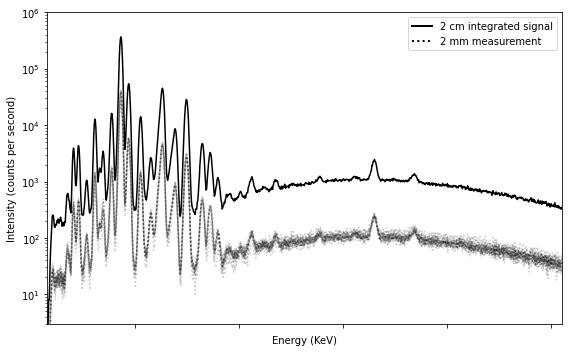

In [56]:
fig,ax=plt.subplots(figsize=(8,5))
cleaned.iloc[:,:10].plot(ax=ax,label='2 mm measurements',legend=False,color='k',ls=':',alpha=.2)
run_summed.iloc[:,5].plot(ax=ax,label='2 cm integrated signal',color='k')
ax.set_yscale('log')
ax.set_xlim(30,1020)
ax.set_ylim(3,1e6)
ax.set_ylabel('Intensity (counts per second)')
ax.set_xlabel('Energy (KeV)')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=2, ls='-',label='2 cm integrated signal'),
                Line2D([0], [0], color='k', lw=2, ls=':',label='2 mm measurement')]
ax.legend(handles=custom_lines)
ax.set_xticklabels([])
plt.tight_layout()
fig.savefig('/Users/danielbabin/Downloads/'+'energy specture.png',dpi=300)

## Make Super Sum Spectra

In [20]:
dct={}
for section in main: 
    file=U1474+section+'/sumspectra.spe'
    dct[section]=pd.read_csv(file,sep='\t',index_col='Date:')
    
df=pd.concat([dct[section].iloc[30:,0].astype(int) for section in main],axis='columns')
df.columns=list(dct.keys())
    
dfm=df.sum(axis=1)/len(main)

In [21]:
product=dct['000_U1474F_1H1']
product.iloc[30:,0]=dfm

results_path='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'
product.to_csv(results_path+'meanspectra.spe',sep='\t')

## Process Problem Sections

#### D4H1

In [22]:
i=19
section=U1474_sections[i]
core=U1474+section+'/XRF data/'

files=listdir(core)
files.sort()

dct={}
for file in files:
        dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')
df=pd.concat([dct[file].iloc[30:,0].astype(int) for file in files],axis='columns')
df.columns=list(dct.keys())

cleaned=df.loc[:,(df.sum()>60000)]
cleaned=cleaned[sorted(cleaned.columns.to_list())]

sumspectra=cleaned.sum(axis=1)
ss_product=dct['L000000.spe']
ss_product.iloc[30:,0]=sumspectra

ss_path='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

run_summed=cleaned.rolling(10,center=True,axis=1).sum()

sum_selected=run_summed.iloc[:,5:-5:10].copy()
colnames=run_summed.iloc[:,:-10:10].columns
for i,col in enumerate(sum_selected.columns):
    sum_selected.rename(columns={col:colnames[i]},inplace=True)
sum_selected_cols=sum_selected.columns

product_dict={}
summed_product_dict={}
for i in cleaned.columns.to_list():
    if i in sum_selected_cols:        
        summed_product_dict[i]=dct[i]
        summed_product_dict[i].iloc[30:,0]=sum_selected[i]
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=cleaned[i]
    else:
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=cleaned[i]

for key in product_dict:
    if key in sum_selected_cols:
        summed_product_dict[key].to_csv(summed_results_path+section+'-'+key,sep='\t')
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')
    else:
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')

#### D8H3

In [23]:
i=55
section=U1474_sections[i]
core=U1474+section+'/XRF data/'

files=listdir(core)
files.sort()

dct={}
for file in files:
        dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')
df=pd.concat([dct[file].iloc[30:,0].astype(int) for file in files],axis='columns')
df.columns=list(dct.keys())

cleaned=df.loc[:,(df.sum()>230000)]

sumspectra=cleaned.sum(axis=1)
ss_product=dct['L000000.spe']
ss_product.iloc[30:,0]=sumspectra

ss_path='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

run_summed=cleaned.rolling(10,center=True,axis=1).sum()

sum_selected=run_summed.iloc[:,5:-5:10].copy()
colnames=run_summed.iloc[:,:-10:10].columns
for i,col in enumerate(sum_selected.columns):
    sum_selected.rename(columns={col:colnames[i]},inplace=True)
sum_selected_cols=sum_selected.columns

product_dict={}
summed_product_dict={}
for i in cleaned.columns.to_list():
    if i in sum_selected_cols:        
        summed_product_dict[i]=dct[i]
        summed_product_dict[i].iloc[30:,0]=sum_selected[i]
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=cleaned[i]
    else:
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=cleaned[i]

for key in product_dict:
    if key in sum_selected_cols:
        summed_product_dict[key].to_csv(summed_results_path+section+'-'+key,sep='\t')
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')
    else:
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')

#### D11H4

In [24]:
i=83
section=U1474_sections[i]
core=U1474+section+'/XRF data/'

files=listdir(core)
files.sort()

dct={}
for file in files:
        dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')
df=pd.concat([dct[file].iloc[30:,0].astype(int) for file in files],axis='columns')
df.columns=list(dct.keys())

cleaned=df.loc[:,(df.sum()>270000)]

sumspectra=cleaned.sum(axis=1)
ss_product=dct['L000000.spe']
ss_product.iloc[30:,0]=sumspectra

ss_path='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

run_summed=cleaned.rolling(10,center=True,axis=1).sum()

sum_selected=run_summed.iloc[:,5:-5:10].copy()
colnames=run_summed.iloc[:,:-10:10].columns
for i,col in enumerate(sum_selected.columns):
    sum_selected.rename(columns={col:colnames[i]},inplace=True)
sum_selected_cols=sum_selected.columns

product_dict={}
summed_product_dict={}
for i in cleaned.columns.to_list():
    if i in sum_selected_cols:        
        summed_product_dict[i]=dct[i]
        summed_product_dict[i].iloc[30:,0]=sum_selected[i]
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=cleaned[i]
    else:
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=cleaned[i]

for key in product_dict:
    if key in sum_selected_cols:
        summed_product_dict[key].to_csv(summed_results_path+section+'-'+key,sep='\t')
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')
    else:
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')

#### D11H5

In [25]:
i=84
section=U1474_sections[i]
core=U1474+section+'/XRF data/'

files=listdir(core)
files.sort()

dct={}
for file in files:
        dct[file]=pd.read_csv(core+file,sep='\t',index_col='Date:')
df=pd.concat([dct[file].iloc[30:,0].astype(int) for file in files],axis='columns')
df.columns=list(dct.keys())

cleaned=df.loc[:,(df.sum()>120000)]

sumspectra=cleaned.sum(axis=1)
ss_product=dct['L000000.spe']
ss_product.iloc[30:,0]=sumspectra

ss_path='/Users/danielbabin/GitHub/U1474_XRF_Data_Report/Data/EXP361-U1474/'+section
ss_product.to_csv(ss_path+'/sumspectra.spe',sep='\t')

run_summed=cleaned.rolling(10,center=True,axis=1).sum()

sum_selected=run_summed.iloc[:,5:-5:10].copy()
colnames=run_summed.iloc[:,:-10:10].columns
for i,col in enumerate(sum_selected.columns):
    sum_selected.rename(columns={col:colnames[i]},inplace=True)
sum_selected_cols=sum_selected.columns

product_dict={}
summed_product_dict={}
for i in cleaned.columns.to_list():
    if i in sum_selected_cols:        
        summed_product_dict[i]=dct[i]
        summed_product_dict[i].iloc[30:,0]=sum_selected[i]
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=cleaned[i]
    else:
        product_dict[i]=dct[i]
        product_dict[i].iloc[30:,0]=cleaned[i]

for key in product_dict:
    if key in sum_selected_cols:
        summed_product_dict[key].to_csv(summed_results_path+section+'-'+key,sep='\t')
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')
    else:
        product_dict[key].to_csv(all_results_path+section+'-'+key,sep='\t')